In [4]:
%matplotlib notebook
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import re
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
import rosbag
from ros_numpy import numpify

In [189]:
class EndPosVelPrediction:

    table_height = 0.76
    table_length = 2.74
    table_width = 1.525
    e = 0.80 				# coefficient of restitution
    ball_radius = 0.02
    g = -9.81

    robot_pos_y = 0.5
    # define the end position of the ball in y-axis
    y_end = -0.15	
    z_end = 0.9		
    ws_radius = 1.6
    # squared value for the max x position that the robot can reach at the defined end y position
    x_limit_squared = ws_radius**2 - (abs(robot_pos_y) - abs(y_end))**2	


    # publish the state immediately if not hittable
    def pubNotHittable(self):
        print("not hittable called")


    # Once receive the initial state of the ball, calculate the predicted end state and publish
    def callback(self, x,y,z,vx,vy,vz):
        y_end = self.y_end
        z_end = self.z_end

        if vy == 0 or vx == 0:
            self.pubNotHittable()
            return

        # check if the ball is not on the table initially
        if (z < self.table_height+self.ball_radius
                or abs(x) > self.table_width/2
                or abs(y) > self.table_length or y > 0):
            self.pubNotHittable()
            print('not on table\n')
            return

        #time for ball to reach the y end position
        t = (y_end - y) / vy
        if t < 0:
            self.pubNotHittable()
            print("wrong direction")
            return

        # check if the final x position is out of the robot workspace
        x_end = x + vx * t
        if x_end**2 > self.x_limit_squared:
            self.pubNotHittable()
            print('final x-position outside of workspace:', x_end)
            return

        # calculate the final z position
        z_temp = z + vz * t + 0.5 * self.g * t**2
        if z_temp > self.table_height+self.ball_radius:
            # ball reaches the final y position without rebound
            #	set to hittable in case the initial state of the ball is after rebound
            # TODO y-position might be too much so ball bounces on very back of table
            # pred_state.pos.z = z_temp
            # pred_state.vel.z = vz + self.g*t
            self.pubNotHittable()
            print("ball will not hit the table\n")
            print("z: ", z, "vz: ", vz, "t: ", t, "z_temp: ", z_temp)
            return

        # Otherwise, ball rebounds at least once

        # find the time for the first rebound
        t_rb1 = (-vz - math.sqrt(vz**2 - 2 * self.g * (z - self.table_height - self.ball_radius))) / self.g
        # find the z velocity just before rebound
        vz_in = -math.sqrt(-2 * self.g * (z - self.table_height - self.ball_radius) + vz**2)
        # find the z velocity just after rebound
        vz_out = -self.e * vz_in

        # time for second rebound
        t_rb2 = 2 * vz_out / -self.g
        # time remains from the first rebound
        t_rem = t - t_rb1
        if t_rb2 < t_rem:
            # second rebound before reaching y end position
            # NOTE: this method may fail if z end position is too close to the table, may need an offset (t_rb2 < t_rem - 0.2?)

            # Quadratic equation z_end = v_z t + .5 a * t^2
            try:
                discrim = math.sqrt(vz_out ** 2 + 2*(self.g)* (z_end - self.table_height - self.ball_radius))
                print(vz_out, z_end)
            except:
                print("cannot find solution")
                return 
            time1, time2 = (-vz_out + discrim)/(-self.g), (-vz_out - discrim)/(-self.g)
            t_hit = None
            choose1, choose2 = True, True
            # time of hit must occur after bounce
            # time of hit must occur before ball goes off table
            print("rebound more than once. quadratic solutions for hitting time:", time1, time2)
            if time1 < 0 or time1 > t_rem or abs(y + (t_rb1 + time1) * vy) > self.ws_radius:
                choose1 = False
            if time2 < 0 or time2 > t_rem or abs(y + (t_rb1 + time2) * vy) > self.ws_radius:
                choose2 = False
            if choose1 == False and choose2 == False:
                print("quadratic didn't find any valid solutions")
                self.pubNotHittable()
                return
            elif choose1 == True and choose2 == True:
                print("quadratic has 2 valid solutions. chose the larger one")
                t_hit = max(time1, time2)
            elif choose1 == True:
                t_hit = time1
            elif choose2 == True:
                t_hit = time2

            t_end = t_rb1 + t_hit
            vz_end = vz_out + self.g * t_hit
            x_end = x + vx*t_end
            y_end = y + vy*t_end
        else:
            z_end = z+vz_out*t_rem + 0.5*self.g*t_rem**2
            vz_end = vz_out + self.g*t_rem
            print("ball rebounds once and hittable\n")
            print(t_rb2, t_rem)
            return x_end, y_end, z_end, x+vx*t_rb1, y+vy*t_rb1, 0.78




In [190]:
def to_numpy(msg):
    return np.array([msg.x, msg.y, msg.z])
def get_trajectories_from_bag(bagfile):
    bag = rosbag.Bag(bagfile)
    topics = ['/ball_detection/ball_pose', '/ball_detection/ball_state_filtered', '/ball_detection/ground_truth', '/ball_detection/predicted_ball_state']
    trajs = [[] for _ in range(len(topics))]
    filtered_vel = []
    time = np.array([])
    for topic, msg, t in bag.read_messages():
        if topic == '/ball_detection/ball_pose':
            trajs[0].append(to_numpy(msg.point))
            time = np.append(time, np.array([msg.header.stamp.secs + msg.header.stamp.nsecs/1e9]))
        elif topic == '/ball_detection/ball_state_filtered':
            trajs[1].append(to_numpy(msg.pos))
            filtered_vel.append(to_numpy(msg.vel))
        elif topic in topics:
            i = topics.index(topic)
            trajs[i].append(to_numpy(msg.pos))
    return [np.array(t).T for t in trajs], np.array(filtered_vel).T, time

In [191]:
bagfile = '/home/imasmm/table-tennis-robot/2020-12-11-03-58-28.bag'
trajs,filtered_vel,time = get_trajectories_from_bag(bagfile)
print([t.shape for t in trajs])
print(filtered_vel.shape)
camera_pos = trajs[0]
filtered_pos = trajs[1]
true_pos = trajs[2]
print(filtered_vel.T)
print(time)

[(3, 71), (3, 1), (3, 4569), (3, 1)]
(3, 1)
[[-0.42941776  3.15072916 -3.51221257]]
[ 5936.42   5936.457  5936.487  5936.519  5936.536  5936.569  5936.588
  5936.612  5936.642  5936.67   5936.693  5936.724  5936.753  5936.77
  5936.787  5936.804  5936.836  5936.853  5936.898  5936.915  5936.933
  5936.961  5936.983  5937.013  5937.046  5937.063  5937.085  5937.104
  5937.129  5937.162  5937.195  5937.212  5937.232  5937.264  5937.293
  5937.316  5937.349  5937.381  5937.398  5937.417  5937.45   5937.468
  5937.486  5937.503  5937.541  5937.558  5937.584  5937.61   5937.641
  5937.668  5937.686  5937.718  5937.735  5937.768  5937.786  5937.819
  5937.851  5937.869  5937.888  5937.92   5937.953  5937.986  5938.03
  5938.049  5938.072  5938.103  5938.121  5938.153  5938.185  5938.202
  5938.221]


In [192]:
mix_x = 0.5
mix_y = 0.5
mix_z = 0.5


def ema(pos,time,direction,mix_constant):
    acc = 0
    if direction == 'x' or direction == 'y':
        acc = 0;
    elif direction == 'z':
        acc = -9.81
    pos_filtered = np.array(pos[0:2])
    vel_filtered = np.array([(pos[1]-pos[0]) / (time[1]-time[0])])
    count_z = 0
    for i in range(2,len(time)):
        dt = time[i]-time[i-1]
        curVel = (pos[i]-pos[i-1]) / dt
        if direction == 'z' and curVel > 0 and count_z < 3:
            vel_filtered = np.append(vel_filtered,curVel)
            pos_filtered = np.append(pos_filtered,pos[i])
            count_z = count_z + 1
            continue
        predVel = vel_filtered[-1] + acc * dt
        estVel = (1-mix_constant) * predVel + mix_constant * curVel
        vel_filtered = np.append(vel_filtered,estVel)
        
        predPos = pos_filtered[-1] + vel_filtered[-2] * dt + 0.5 * acc * dt**2
        estPos = (1-mix_constant) * predPos + mix_constant * pos[i]
        pos_filtered = np.append(pos_filtered,estPos)
                             
    return pos_filtered, vel_filtered


# need at least N data points to precisely determine the end position and velocity
data_size = 15
[x_kalman,vx_kalman] = ema(camera_pos[0][0:data_size], time[0:data_size], 'x', mix_x)   
[y_kalman,vy_kalman] = ema(camera_pos[0][0:data_size], time[0:data_size], 'y', mix_y)  
[z_kalman,vz_kalman] = ema(camera_pos[0][0:data_size], time[0:data_size], 'z', mix_z)  

<IPython.core.display.Javascript object>


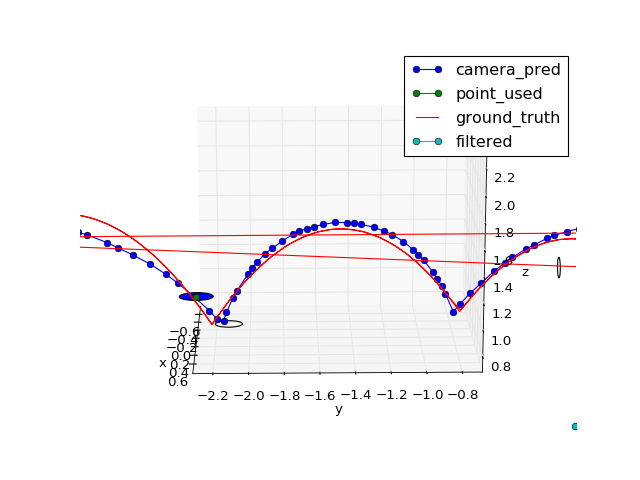

ball rebounds once and hittable

0.668802440848 0.626651378015


In [193]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(camera_pos[0], camera_pos[1], camera_pos[2], label='camera_pred', marker='o')
ax.plot(filtered_pos[0], filtered_pos[1], filtered_pos[2], label='point_used', marker='o')
ax.plot(true_pos[0], true_pos[1], true_pos[2], label='ground_truth')
ax.plot(x_kalman, y_kalman, z_kalman, label='filtered', marker='o')

time = 0
p = Circle((filtered_pos[0][time],filtered_pos[1][time]), 0.1, fill=True)
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=filtered_pos[2][time], zdir="z")


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.xlim([-1.5,1.5])
plt.ylim([-3,0])
ax.set_zlim([0,3])
ax.legend()

paddle_radius = .08

predict = EndPosVelPrediction()
end_state = np.zeros([1,6])
end_state = predict.callback(filtered_pos[0][time],filtered_pos[1][time],filtered_pos[2][time],\
                filtered_vel[0][time], filtered_vel[1][time], filtered_vel[2][time])
end = end_state[0:3]
land = end_state[3:6]


p_end = Circle((end[0],end[2]), paddle_radius, fill=False)
ax.add_patch(p_end)
art3d.pathpatch_2d_to_3d(p_end, z=end[1], zdir="y")

p_land = Circle(land[0:2], paddle_radius, fill=False)
ax.add_patch(p_land)
art3d.pathpatch_2d_to_3d(p_land, z=land[2], zdir="z")


plt.show()